<a href="https://colab.research.google.com/github/chtozaserikova/Student_Identification_System/blob/develop/research/research_of_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Исследования самых популярных метрик качества детекции объектов (пока что на примере других рандомных картинок)

## Теоретическая справка








### <a id="definition">Определение</a>
**mAP (mean average precision)** — это метрика, используемая для оценки точности, в нашем случае, для задач обнаружения объектов . Как правило, для расчета mAP для пользовательской модели, обученной задачам обнаружения объектов , сначала вычисляется средняя точность для каждого класса в пользовательской модели. Затем среднее значение этих рассчитанных средних значений точности по всем классам дает mAP . Обращать внимание! В некоторых документах средняя точность и mAP взаимозаменяемы.

**Intersection Over Union (IoU)** - это мера, которая используется для оценки перекрытия между двумя ограничивающими рамками (BB) . IoU показывает, насколько предсказанный BB перекрывается с так называемым Ground Truth BB (тот, который имеет реальный объект внутри). Сравнивая IoU с порогом, можно определить, является ли предсказанный BB истинно положительным (действительным, другими словами) или ложноположительным (недействительным). IoU рассчитывается путем деления площади перекрытия между предсказанным BB и Ground Truth BB на площадь объединения двух BB .как показано на рисунке ниже. Пересечение над объединением (IoU)


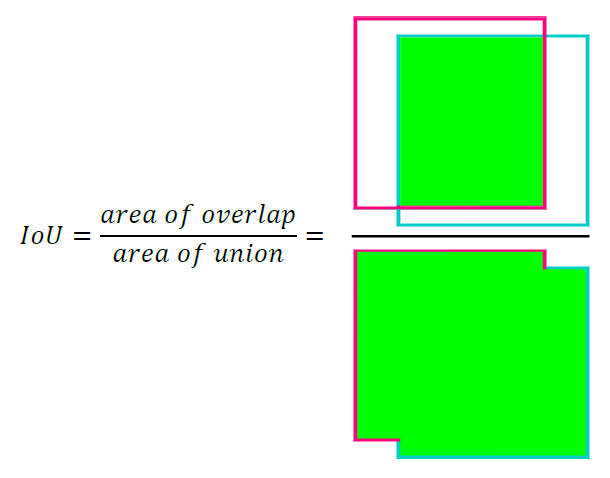

In [30]:
from IPython.display import Image
Image('/content/iou.png')

### <a id="average-precision">Расчет Average Precision (AP)</a>
AP рассчитывается с учетом площади под кривой Interpolated Precision and Recall . Во- первых, значения отзыва делятся на 11 точек следующим образом: [0, 0,1, 0,2 … 1] , как показано на рисунке ниже.

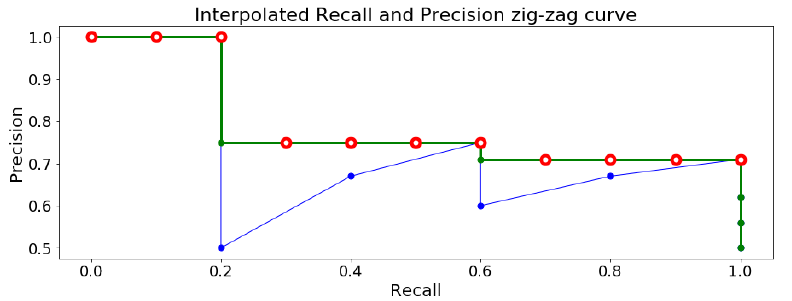

In [31]:
from IPython.display import Image
Image('/content/ap_curve.png')

Затем для этих 11 точек возврата вычисляется среднее значение максимальной точности.

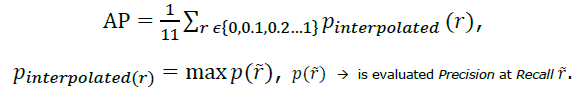

In [32]:
from IPython.display import Image
Image('/content/ap.png')

В нашем примере АР будет рассчитываться следующим образом:

<br/>**AP = (1/11) * (1+1+1+0.75+0.75+0.75+0.75+0.71+0.71+0.71+0.71) = 0.81**
<br/>

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from collections import Counter

In [27]:
num2class = {"0.0" : "buffalo", "1.0" : "elephant", "2.0" : "rhino", "3.0" : "zebra"}

## Bounding boxes

In [ ]:
# box : (centerX, centerY, width, height)
def convertToAbsoluteValues(size, box):
    
    xIn = round(((2 * float(box[0]) - float(box[2])) * size[0] / 2))
    yIn = round(((2 * float(box[1]) - float(box[3])) * size[1] / 2))
    xEnd = xIn + round(float(box[2]) * size[0])
    yEnd = yIn + round(float(box[3]) * size[1])
    
    if xIn < 0:
        xIn = 0
    if yIn < 0:
        yIn = 0
    if xEnd >= size[0]:
        xEnd = size[0] - 1
    if yEnd >= size[1]:
        yEnd = size[1] - 1
    return (xIn, yIn, xEnd, yEnd)

In [ ]:
def boundingBoxes(labelPath, imagePath):
    
    detections, groundtruths, classes = [], [], []
    
    for boxtype in os.listdir(labelPath):

        boxtypeDir = os.path.join(labelPath,boxtype)

        for labelfile in os.listdir(boxtypeDir):
            filename = os.path.splitext(labelfile)[0]
            with open(os.path.join(boxtypeDir, labelfile)) as f:
                labelinfos = f.readlines()

            imgfilepath = os.path.join(imagePath, filename + ".jpg")
            img = cv.imread(imgfilepath)
            h, w, _ = img.shape

            for labelinfo in labelinfos:
                label, conf, rx1, ry1, rx2, ry2 = map(float, labelinfo.strip().split())
                x1, y1, x2, y2 = convertToAbsoluteValues((w, h), (rx1, ry1, rx2, ry2))
                boxinfo = [filename, label, conf, (x1, y1, x2, y2)]
                
                if label not in classes:
                    classes.append(label)
                
                if boxtype == "detection":
                    detections.append(boxinfo)
                else:
                    groundtruths.append(boxinfo)
                    
    classes = sorted(classes)
                
    return detections, groundtruths, classes

detections, groundtruths, classes = boundingBoxes("label", "image")
print(detections)
print(groundtruths)
print(classes)

IsADirectoryError: ignored

##Plot Bounding boxes

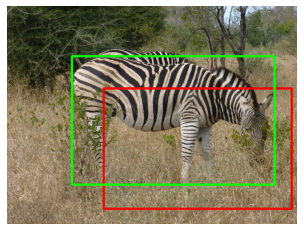

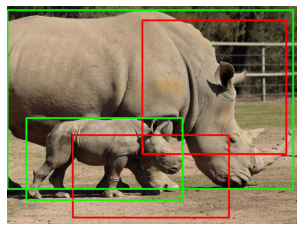

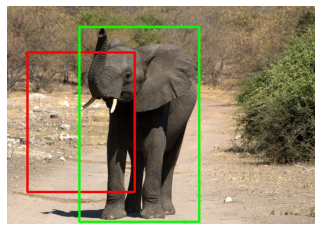

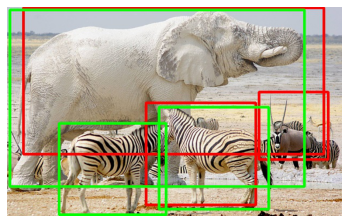

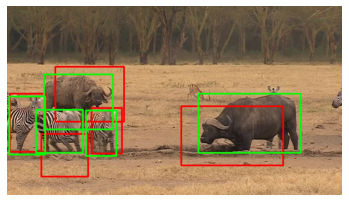

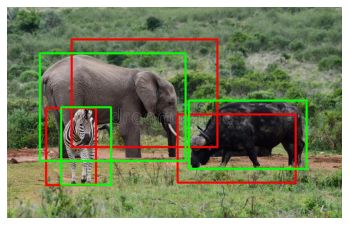

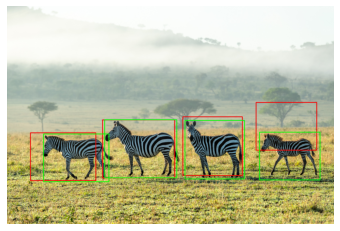

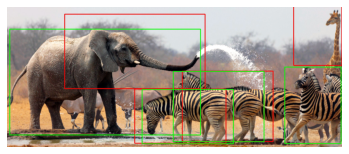

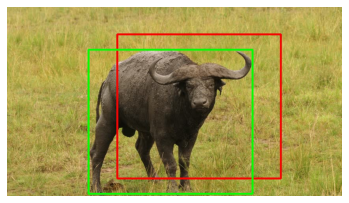

In [ ]:
def boxPlot(boxlist, imagePath, savePath):
    labelfiles = sorted(list(set([filename for filename, _, _, _ in boxlist])))
    
    for labelfile in labelfiles:
    
        rectinfos = []
        imgfilePath = os.path.join(imagePath, labelfile + ".jpg")
        img = cv.imread(imgfilePath)

        for filename, _, conf, (x1, y1, x2, y2) in boxlist:
            if labelfile == filename:
                rectinfos.append((x1, y1, x2, y2, conf))
                
        for x1, y1, x2, y2, conf in rectinfos:
            
            if conf == 1.0:
                rectcolor = (0, 255, 0)
            else:
                rectcolor = (0, 0, 255)
                
            cv.rectangle(img, (x1, y1), (x2, y2), rectcolor, 4)
        cv.imwrite(f"{savePath}/{labelfile}.jpg", img)

        img = mpimg.imread(f"{savePath}/{labelfile}.jpg")
        plt.axis("off")
        plt.imshow(img)
        plt.show()
        
boxPlot(detections + groundtruths, "image", savePath="boxed_images/both")

## IoU(Intersection over Union)

In [ ]:
def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)


def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)
    
    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
        
    return float(area_A + area_B - interArea)

def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

# boxA = (Ax1,Ay1,Ax2,Ay2)
# boxB = (Bx1,By1,Bx2,By2)
def boxesIntersect(boxA, boxB):
    if boxA[0] > boxB[2]:
        return False  # boxA is right of boxB
    if boxB[0] > boxA[2]:
        return False  # boxA is left of boxB
    if boxA[3] < boxB[1]:
        return False  # boxA is above boxB
    if boxA[1] > boxB[3]:
        return False  # boxA is below boxB
    return True

def iou(boxA, boxB):
    # if boxes dont intersect
    if boxesIntersect(boxA, boxB) is False:
        return 0
    interArea = getIntersectionArea(boxA, boxB)
    union = getUnionAreas(boxA, boxB, interArea=interArea)
    
    # intersection over union
    result = interArea / union
    assert result >= 0
    return result

In [ ]:
boxA = detections[-1][-1]
boxB = groundtruths[-1][-1]

print(f"boxA coordinates : {(boxA)}")
print(f"boxA area : {getArea(boxA)}")
print(f"boxB coordinates : {(boxB)}")
print(f"boxB area : {getArea(boxB)}")

print(f"Union area of boxA and boxB : {getUnionAreas(boxA, boxB)}")

print(f"Does boxes Intersect? : {boxesIntersect(boxA, boxB)}")

print(f"Intersection area of boxA and boxB : {getIntersectionArea(boxA, boxB)}")

print(f"IoU of boxA and boxB : {iou(boxA, boxB)}")

boxA coordinates : (280, 69, 696, 435)
boxA area : 153039
boxB coordinates : (207, 108, 624, 474)
boxB area : 153406
Union area of boxA and boxB : 193285.0
Does boxes Intersect? : True
Intersection area of boxA and boxB : 113160
IoU of boxA and boxB : 0.5854567090048374


## AP(Average Precision)

In [ ]:
def calculateAveragePrecision(rec, prec):
    
    mrec = [0] + [e for e in rec] + [1]
    mpre = [0] + [e for e in prec] + [0]

    for i in range(len(mpre)-1, 0, -1):
        mpre[i-1] = max(mpre[i-1], mpre[i])

    ii = []

    for i in range(len(mrec)-1):
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i+1)

    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i-1]) * mpre[i])
    
    return [ap, mpre[0:len(mpre)-1], mrec[0:len(mpre)-1], ii]

In [ ]:
def ElevenPointInterpolatedAP(rec, prec):

    mrec = [e for e in rec]
    mpre = [e for e in prec]

    recallValues = np.linspace(0, 1, 11)
    recallValues = list(recallValues[::-1])
    rhoInterp, recallValid = [], []

    for r in recallValues:
        argGreaterRecalls = np.argwhere(mrec[:] >= r)
        pmax = 0

        if argGreaterRecalls.size != 0:
            pmax = max(mpre[argGreaterRecalls.min():])

        recallValid.append(r)
        rhoInterp.append(pmax)

    ap = sum(rhoInterp) / 11

    return [ap, rhoInterp, recallValues, None]

In [ ]:
def AP(detections, groundtruths, classes, IOUThreshold = 0.3, method = 'AP'):
    
    result = []
    
    for c in classes:

        dects = [d for d in detections if d[1] == c]
        gts = [g for g in groundtruths if g[1] == c]

        npos = len(gts)

        dects = sorted(dects, key = lambda conf : conf[2], reverse=True)

        TP = np.zeros(len(dects))
        FP = np.zeros(len(dects))

        det = Counter(cc[0] for cc in gts)

        # 각 이미지별 ground truth box의 수
        # {99 : 2, 380 : 4, ....}
        # {99 : [0, 0], 380 : [0, 0, 0, 0], ...}
        for key, val in det.items():
            det[key] = np.zeros(val)


        for d in range(len(dects)):


            gt = [gt for gt in gts if gt[0] == dects[d][0]]

            iouMax = 0

            for j in range(len(gt)):
                iou1 = iou(dects[d][3], gt[j][3])
                if iou1 > iouMax:
                    iouMax = iou1
                    jmax = j

            if iouMax >= IOUThreshold:
                if det[dects[d][0]][jmax] == 0:
                    TP[d] = 1
                    det[dects[d][0]][jmax] = 1
                else:
                    FP[d] = 1
            else:
                FP[d] = 1

        acc_FP = np.cumsum(FP)
        acc_TP = np.cumsum(TP)
        rec = acc_TP / npos
        prec = np.divide(acc_TP, (acc_FP + acc_TP))

        if method == "AP":
            [ap, mpre, mrec, ii] = calculateAveragePrecision(rec, prec)
        else:
            [ap, mpre, mrec, _] = ElevenPointInterpolatedAP(rec, prec)

        r = {
            'class' : c,
            # 'precision' : prec,
            # 'recall' : rec,
            'AP' : ap,
            # 'interpolated precision' : mpre,
            # 'interpolated recall' : mrec,
            # 'total positives' : npos,
            # 'total TP' : np.sum(TP),
            # 'total FP' : np.sum(FP)
        }

        result.append(r)

    return result

result = AP(detections, groundtruths, classes)
print(result)

[{'class': 0.0, 'AP': 0.75}, {'class': 1.0, 'AP': 0.375}, {'class': 2.0, 'AP': 1.0}, {'class': 3.0, 'AP': 0.4387755102040817}]


In [ ]:
def mAP(result):
    ap = 0
    for r in result:
        ap += r['AP']
    mAP = ap / len(result)
    
    return mAP

In [ ]:
for r in result:
    print("{:^8} AP : {}".format(num2class[str(r['class'])], r['AP']))
print("---------------------------")
print(f"mAP : {mAP(result)}")

buffalo  AP : 0.75
elephant AP : 0.375
 rhino   AP : 1.0
 zebra   AP : 0.4387755102040817
---------------------------
mAP : 0.6409438775510204


## mAP(mean Average Precision)

In [25]:
def mAP(result):
    ap = 0
    for r in result:
        ap += r['AP']
    mAP = ap / len(result)
    
    return mAP

In [28]:
for r in result:
    print("{:^8} AP : {}".format(num2class[str(r['class'])], r['AP']))
print("---------------------------")
print(f"mAP : {mAP(result)}")

buffalo  AP : 0.75
elephant AP : 0.375
 rhino   AP : 1.0
 zebra   AP : 0.4387755102040817
---------------------------
mAP : 0.6409438775510204
